# Artifact 3 Description
This test...

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys 

from datetime import datetime as DT

sys.path.append("..")
from plot_style import *

In [2]:
sync_df = pd.read_feather("out/sync-v2.feather")
async_df = pd.read_feather("out/async.feather")
async_df.head()

,train/acc,train/loss,train/epoch,train/batch_idx,train/time,training_start,training_end,node/idx,node/kind,parent/idx,parent/kind,round,train/rel_time,strategy,mode,workers
0,0.31250,2.297922,0,0,2024-04-01 23:27:13.027266,2024-04-01 23:27:12.914983,2024-04-01 23:27:41.179950,2,worker,0,leader,0,4.762195,FedAsync,async,12
1,0.15625,2.321715,0,1,2024-04-01 23:27:13.070513,2024-04-01 23:27:12.914983,2024-04-01 23:27:41.179950,2,worker,0,leader,0,4.805442,FedAsync,async,12
2,0.21875,2.317055,0,2,2024-04-01 23:27:13.125010,2024-04-01 23:27:12.914983,2024-04-01 23:27:41.179950,2,worker,0,leader,0,4.859939,FedAsync,async,12
3,0.09375,2.333768,0,3,2024-04-01 23:27:13.177854,2024-04-01 23:27:12.914983,2024-04-01 23:27:41.179950,2,worker,0,leader,0,4.912783,FedAsync,async,12
4,0.28125,2.301785,0,4,2024-04-01 23:27:13.268923,2024-04-01 23:27:12.914983,2024-04-01 23:27:41.179950,2,worker,0,leader,0,5.003852,FedAsync,async,12


In [3]:
def get_workers_rounds(df: pd.DataFrame) -> tuple[list, list]:
    df_workers = df.query("`node/kind` == 'worker'")["node/idx"].unique()
    df_workers = list(df_workers)
    df_workers = sorted(df_workers)

    df_rounds = df["round"].unique()
    df_rounds = list(df_rounds)
    df_rounds = sorted(df_rounds)

    return df_workers, df_rounds


def plot_execution_schedule(
        df: pd.DataFrame,
        relative_time: bool = True,
        rel_time_format: str = "%H:%M:%S",
        ax=None
):
    if ax is None:
        _, ax = plt.subplots()

    workers, rounds = get_workers_rounds(df)
    worker_start_ends = {
        w: {
            "start": DT(year=2999, month=1, day=1), 
            "end": DT(year=1900, month=1, day=1), 
            "total_active_time": 0
        }
        for w in workers
    }
    color_cycler = ("tab:red", "tab:green", "tab:blue", "tab:orange", "tab:pink")
    for w in workers:
        colors = []
        x_bars = []
        for r in rounds:
            tmp = df.query(f"`node/idx` == {w} and round == {r}")
            tup = tmp.iloc[0]

            start = tup["training_start"].to_pydatetime()
            end = tup["training_end"].to_pydatetime()

            delta = (end - start)
            x_bars.append((start, delta))
            colors.append(color_cycler[r % len(color_cycler)])

            worker_start_ends[w]["start"] = min(worker_start_ends[w]["start"], start)
            worker_start_ends[w]["end"] = max(worker_start_ends[w]["end"], end)
            worker_start_ends[w]["total_active_time"] += delta.total_seconds()

        height = (w - 0.5, 1)
        ax.broken_barh(x_bars, height, facecolors=colors)

    if relative_time:
        ground_start = df.training_start.min()
        ground_start = ground_start.strftime(rel_time_format)
        ground_start = DT.strptime(str(ground_start), rel_time_format)

        ticks = ax.get_xticks()
        tick_labels = ax.get_xticklabels()
        tick_labels = [lab.get_text() for lab in tick_labels]
        tick_label_dts = [DT.strptime(lab, rel_time_format) for lab in tick_labels]

        new_tick_labels = [
            (dt - ground_start).total_seconds()
            for dt in tick_label_dts
        ]
        ax.set_xticks(ticks, new_tick_labels)

    # Here, we are interested in calculating the statistics on how often each worker sits idle.
    # We expect that this will show a notable advantage of async FL over standard sync FL.
    headers = ["worker_id", "total_active_time", "runtime", "idle_percent"]
    idle_table = []
    for w, worker_data in worker_start_ends.items():
        active_time = worker_data["total_active_time"]
        completion_time = (worker_data["end"] - worker_data["start"]).total_seconds()
        percent_idle = (1 - active_time / completion_time) * 100
        idle_table.append([w, active_time, completion_time, percent_idle])

    idle_df = pd.DataFrame(idle_table, columns=headers)
    return ax, idle_df

In [4]:
_, async_idle_df = plot_execution_schedule(
    async_df, relative_time=True, rel_time_format="%d %H:%M"
)
plt.close()

display(async_idle_df)
idle = async_idle_df.idle_percent
print(f"(async) Idle Time (%) Avg.:      {idle.mean():0.5f}")
print(f"(async) Idle Time (%) Std. Dev.: {idle.std():0.5f}")

,worker_id,total_active_time,runtime,idle_percent
0,1,1108.301951,1108.704391,0.036298
1,2,705.796479,706.426842,0.089233
2,3,1040.313839,1041.121546,0.077580
3,4,1134.401477,1135.016557,0.054191
4,5,1201.891347,1202.598116,0.058770
5,6,1149.363816,1150.006289,0.055867
6,7,1215.391632,1215.943563,0.045391
7,8,994.087382,994.788551,0.070484
8,9,1121.805252,1122.575175,0.068585
9,10,1200.680023,1201.328345,0.053967


(async) Idle Time (%) Avg.:      0.06067
(async) Idle Time (%) Std. Dev.: 0.01457


In [5]:
_, sync_idle_df = plot_execution_schedule(
    sync_df, relative_time=True, rel_time_format="%d %H:%M"
)
plt.close()

display(sync_idle_df)
idle = sync_idle_df.idle_percent
print(f"(async) Idle Time (%) Avg.:      {idle.mean():0.5f}")
print(f"(async) Idle Time (%) Std. Dev.: {idle.std():0.5f}")

,worker_id,total_active_time,runtime,idle_percent
0,1,1238.476370,1340.906747,7.638889
1,2,700.099633,1314.430011,46.737397
2,3,1096.404198,1336.352000,17.955434
3,4,1194.423092,1338.947459,10.793879
4,5,1260.922945,1342.164174,6.053002
5,6,1242.465869,1340.563393,7.317634
6,7,1284.003529,1343.189501,4.406375
7,8,1013.607240,1327.039493,23.618909
8,9,1151.220491,1337.103504,13.901917
9,10,1280.261047,1342.420090,4.630372


(async) Idle Time (%) Avg.:      14.85836
(async) Idle Time (%) Std. Dev.: 11.81620


# Artifact 3
...

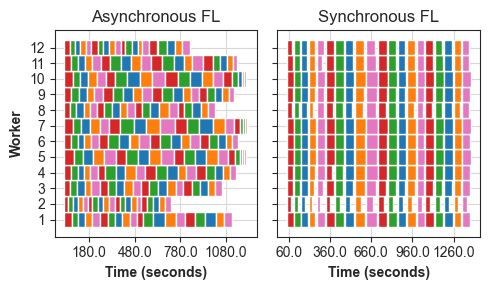

In [6]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3), sharey=True)
plot_execution_schedule(
    async_df, relative_time=True, ax=axes[0], rel_time_format="%d %H:%M"
)
plot_execution_schedule(
    sync_df, relative_time=True, ax=axes[1], rel_time_format="%d %H:%M"
)

ticks = list(range(1, 12+1))
axes[0].set_yticks(ticks, ticks)
axes[1].set_yticks(ticks, ticks)

axes[0].set_ylabel("Worker", weight="bold")
axes[0].set_xlabel("Time", weight="bold")
axes[1].set_xlabel("Time", weight="bold")

axes[0].set_xlabel("Time (seconds)", weight="bold")
axes[1].set_xlabel("Time (seconds)", weight="bold")

axes[0].set_title("Asynchronous FL", weight="normal")
axes[1].set_title("Synchronous FL", weight="normal")

plt.tight_layout()
plt.savefig("artifact_3.pdf", bbox_inches="tight")
plt.show()

## Async vs. Sync: Accuracy Comparison
Here, we compare the training accuracy provided by synchronous FL and asynchronous FL. Rough estiamtes of these numbers in the final round are provided in the submitted manuscript.

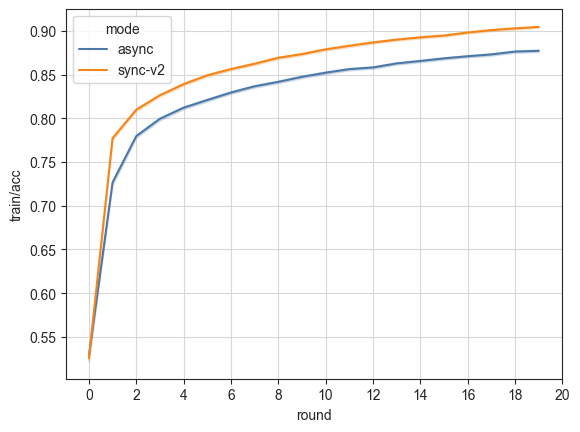

In [7]:
tmp = pd.concat([async_df, sync_df])
sns.lineplot(
    tmp,
    x="round",
    y="train/acc",
    hue="mode",
)
ticks = list(range(0, 20 + 1, 2))
plt.xticks(ticks, ticks)
plt.show()